# Classification and Clustering
Détection d'intrusion à partir du dataset NSL-KDD, dérivé du dataset [KDD99](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). [Description complète du challenge original (1999)](http://kdd.ics.uci.edu/databases/kddcup99/task.html).

> The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between "bad" connections, called intrusions or attacks, and "good" normal connections. This database contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment.




Quatre catégories d'attaques dans ce dataset (cf [taxonomy](http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types)) :
> - **DOS**: denial-of-service, e.g. syn flood;
> - **R2L**: unauthorized access from a remote machine, e.g. guessing password;
> - **U2R**:  unauthorized access to local superuser (root) privileges, e.g., various buffer overflow attacks;
> - **probing**: surveillance and other probing, e.g., port scanning.

Catégorie | Attaques
--- | --- 
dos | back,land,neptune,pod,smurf,teardrop
probe | ipsweep,nmap,portsweep,satan
r2l | ftp_write,guess_passwd,imap,multihop,phf,spy,warezclient,warezmaster
u2r | buffer_overflow,loadmodule,perl,rootkit

## Objectifs pédagogiques
- [**done**] loader et préparer les données
- classification avec Random Forest, Naive Bayes
- clustering avec K-means, DBSCAN
- évaluation de la classification avec des performance metrics
- évaluation du clustering naive en utilisant les catégories d'attaque
- évaluation du clustering avec des performance metrics
- *(optionel) visualisation avec t-SNE*
- *(optionel) clustering avec d'autres techniques*

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import os

# Data

## Load dataset

In [ ]:
# if data stored locally
# dataset_path = os.path.join('.', 'dataset')
# train20_path = os.path.join(dataset_path, 'KDDTrain+_20Percent.txt')
# train_path = os.path.join(dataset_path, 'KDDTrain+.txt')
# test_path = os.path.join(dataset_path, 'KDDTest+.txt')

In [ ]:
dataset_path = 'https://raw.githubusercontent.com/laure-delisle/intro-ml/master/dataset/'
train20_path = dataset_path + 'KDDTrain+_20Percent.txt'
train_path = dataset_path +'KDDTrain+.txt'
test_path = dataset_path + 'KDDTest+.txt'

In [ ]:
col_names = np.array(["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels", "foo"])

In [ ]:
attack_types = {
    'normal': 'normal',
    
    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',
    
    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',
    
    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',    
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}

In [ ]:
categorical_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numerical_idx= list(set(range(41)).difference(categorical_idx).difference(binary_idx))

categorical_cols = col_names[categorical_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numerical_cols = col_names[numerical_idx].tolist()

In [ ]:
def load_data(data_path):
    df = pd.read_csv(data_path, header=None, index_col=False, names=col_names).drop("foo", axis='columns')
    df['attack_type'] = df.labels.apply(lambda attack: attack_types[attack])
    
    # casting
    df = df.astype({col: 'category' for col in categorical_cols}, copy=False)
    df = df.astype({col: np.float32 for col in numerical_cols}, copy=False)
    
    return df

In [ ]:
df_train20 = load_data(train20_path)
df_train = load_data(train_path)
df_test = load_data(test_path)
df_data = pd.concat([df_train, df_test])

In [ ]:
df_train20.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels,attack_type
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,DoS
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,normal


In [ ]:
df_train20.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054108,2.433007e+04,3.491837e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,182.532074,115.063034,0.519772,0.082540,0.147457,0.031845,0.285797,0.279844,0.117800,0.118770
std,2686.677979,2.410689e+06,8.883027e+04,0.008910,0.260243,0.00630,2.154169,0.045416,0.488811,10.417086,...,98.986549,110.648399,0.448945,0.187195,0.308354,0.110563,0.445332,0.446065,0.305896,0.317376
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Séparation données / label

In [ ]:
var_names = np.array(["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate"])
target_name = np.array(["attack_type"])

In [ ]:
#alternative
col_names = np.array(df_train.columns)
var_names = col_names[:-1]
target_name = col_names[-1]

In [ ]:
target_name

'attack_type'

In [ ]:
var_names

array(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'labels'], dtype=object)

In [ ]:
# we will need to drop 'labels' later on,
# it is directly correlated with 'attack_type'
'labels' in var_names

True

# One Hot encoding pour les variables catégoriques
Aussi appelé 'dummies'. Transformation d'une colonne à N valeurs catégoriques en N colonnes à valeurs binaires :

| categ_var |
|-----------|
| TCP       |
| UDP       |
| TCP       |
| ICMP      |

devient ainsi :

| categ_var_tcp | categ_var_udp | categ_var_icmp |
|---------------|---------------|----------------|
| 1             | 0             | 0              |
| 0             | 1             | 0              |
| 1             | 0             | 0              |
| 0             | 0             | 1              |

En utilisant `sklearn.preprocessing.OneHotEncoder`

*doc: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html*

ou bien en utilisant `pd.get_dummies`

*doc: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html*

Un autre encoding est un encoding numérique en utilisant `sklearn.preprocessing.LabelEncoder`. Ce dernier permet de ne pas changer le nombre de variables, et fonctionne très bien qvec des modèles de type XGBoost et Random Forests.

*doc: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html*

In [ ]:
# colonnes à transformer
categorical_cols

['protocol_type', 'service', 'flag']

In [ ]:
# Par exemple, la variable catégorique "protocol" prend 3 valeurs au format string
df_data.protocol_type.value_counts()

tcp     121569
udp      17614
icmp      9334
Name: protocol_type, dtype: int64

In [ ]:
dummies = pd.get_dummies(df_data[categorical_cols])
df_dummies = pd.concat([df_data, dummies], axis=1)
df_dummies.drop('labels', axis='columns', inplace=True)
df_dummies.drop(categorical_cols, axis='columns', inplace=True)

In [ ]:
df_dummies.head(2)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,491.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,146.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
dummies_names = df_dummies.drop('attack_type', axis='columns', inplace=False).columns
dummies_names

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR', 'flag_S0',
       'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH'],
      dtype='object', length=122)

# Recap preparation données

### Etapes :
1- charger les données\
2- identifier les variables et la cible\
3- transformer les variables catégoriques en binaire (dummies = one-hot encoding)\

### Variables utiles :
Variables sur lesquelles entraîner le modèle : **dummies_names**\
Variable cible que l'on cherche à prédire : **target_name**\
Tableau contenant toutes les données préparées : **df_dummies**

# Train-test split

A effectuer sur `df_dummies` en utilisant `sklearn.model_selection.train_test_split`

*doc: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html*

In [ ]:
from sklearn import model_selection

In [ ]:
X_train, X_test, y_train, y_test = # .... A faire

Vérification de la taille des sets obtenus, et des proportions (80% / 20%)

In [ ]:
# .... A faire

# Classification
Quelques liens utiles :
- https://scikit-learn.org/stable/modules/tree.html#classification
- https://scikit-learn.org/stable/modules/ensemble.html#random-forests
- https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes

astuce 1: pour enlever le Warning: "*FutureWarning: Feature names only support names that are all strings.*", utiliser les valeurs du dataframe sans les noms de colonnes en appliquant **.values** (ex: X_train.values) \
astuce 2: to flatten a numpy array, we can use .reshape(-1) or ravel() or .values()

steps:
 - 1 define classifier
 - 2 fit on train set
 - 3 score on **test** set

In [ ]:
from sklearn import ensemble, tree, naive_bayes

In [ ]:
# exemple avec un Random Forest contenant 50 arbres
# .... A faire

0.995253164556962

In [ ]:
# exemple avec un Random Forest contenant 10 arbres et une profondeur max de 3 noeuds
# .... A faire

0.8964785887422569

# Mesure de performance - classification
Essayez d'obtenir:
- accuracy
- precision
- recall
- confusion matrix
- false positive rate

*doc: https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics*

In [ ]:
from sklearn import metrics

In [ ]:
y_pred = # .... A faire

In [ ]:
# Mesurer la performance avec une matrice de confusion
conf_matrix = # .... A faire

In [ ]:
# code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          cmap=plt.cm.Blues):

    title = 'Confusion matrix'
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

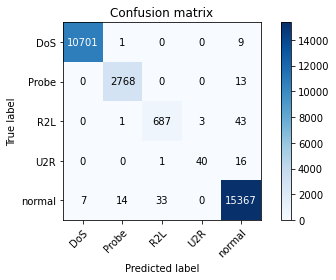

In [ ]:
plot_confusion_matrix(cm=conf_matrix, classes=['DoS', 'Probe', 'R2L', 'U2R', 'normal'])

# Unbalanced dataset

Quand on impose des contraintes plus strictes sur notre modèle, on favorise les classes majoritaires (ici DOS, Probe, Normal)

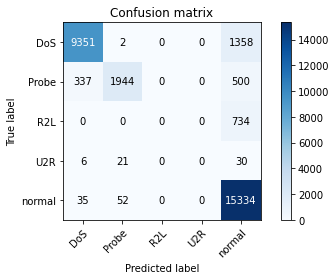

In [ ]:
# exemple avec un Random Forest contenant 10 arbres et une profondeur max de 3 noeuds
clf = # .... A faire
y_pred = # .... A faire
conf_matrix = # .... A faire
plot_confusion_matrix(cm=conf_matrix, classes=['DoS', 'Probe', 'R2L', 'U2R', 'normal'])

# Clustering
Some pointers:
- https://scikit-learn.org/stable/modules/clustering.html#k-means
- https://scikit-learn.org/stable/modules/clustering.html#dbscan

In [ ]:
# Normalization
X_dummies = pd.concat([X_train, X_test])
X_normalized = X_dummies.apply(lambda x: (x * 1.0)/ x.max())
X_normalized_no_na = X_normalized.dropna(axis='columns')

In [ ]:
from sklearn import cluster

In [ ]:
# .... A faire

# Mesure de performance - classification
Essayez d'obtenir:
- silhouette
- homogénéité

*doc: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation*